<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Assignment-Tasks" data-toc-modified-id="Assignment-Tasks-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Assignment Tasks</a></span></li><li><span><a href="#Match-r/i/z-catalogs-to-PanSTARRS" data-toc-modified-id="Match-r/i/z-catalogs-to-PanSTARRS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Match r/i/z catalogs to PanSTARRS</a></span></li><li><span><a href="#Reading-SExtractor-.cat-file" data-toc-modified-id="Reading-SExtractor-.cat-file-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reading SExtractor .cat file</a></span></li><li><span><a href="#Converting-to-SkyCoord-Objects" data-toc-modified-id="Converting-to-SkyCoord-Objects-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Converting to SkyCoord Objects</a></span></li><li><span><a href="#Matching-SE-Coordinates-to-Catalog" data-toc-modified-id="Matching-SE-Coordinates-to-Catalog-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Matching SE Coordinates to Catalog</a></span></li><li><span><a href="#Curve-Fitting" data-toc-modified-id="Curve-Fitting-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Curve Fitting</a></span></li><li><span><a href="#Execute" data-toc-modified-id="Execute-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Execute</a></span></li><li><span><a href="#SVR" data-toc-modified-id="SVR-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>SVR</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Color-Color-Plots" data-toc-modified-id="Color-Color-Plots-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Color Color Plots</a></span></li><li><span><a href="#Reading-in-SED" data-toc-modified-id="Reading-in-SED-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Reading in SED</a></span></li><li><span><a href="#Using-UH88-Quantum-Efficiency" data-toc-modified-id="Using-UH88-Quantum-Efficiency-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Using UH88 Quantum Efficiency</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from scipy.odr import ODR, Model, Data, RealData
from uncertainties import ufloat, unumpy

In [2]:
main_dir = "/Volumes/LaCie/School/ASTR_301/Object Catalogs/NEP_5281/"

## Assignment Tasks

___
1. Match r/i/z catalogs to PanSTARRS
1. Determine zero point offset, possible color term.
    $$PS_{M_i} = A \cdot M_i + ZP + [B \cdot (M_r-M_i)+C \cdot(M_i - M_z)]$$
1. Make calibrated catalogs
1. Plot PanSTARRS mag against observed
___
**OPTIONAL**
1. Compute galaxy colors and compare to your model colors
    1. Calculate observed r-i, i-z
    1. Overlay models
    1. Find closest match by finding reasonble redshift
1. Look at error in magnitude and propagate
    1. Find error in r-i, i-z
    1. Determine what range of z or models fits within the errors
1. Plot Error against Mag

## Match r/i/z catalogs to PanSTARRS
___

* Use the [PanSTARRS Database](http://mastweb.stsci.edu/ps1casjobs/) and run an SQL query to extract panstarrs data on galaxy of choice.
* Use Astropy match_coordinates_sky
    ```python
    from astropy.coordinates import match_coordinates_sky
    ```
* Note that PanSTARRS catalog only includes highly sampled targets, therefore there will be less objects within the field.

## Reading SExtractor .cat file

In [3]:
def parse_cat(obj ,filter):
    data = ascii.read(main_dir+"{}_{}.cat".format(obj,filter))
    data.write(main_dir+"SE_{}.csv".format(filter), format="csv")
    
    df = pd.read_csv(main_dir+"SE_{}.csv".format(filter))
    df = df.drop(["NUMBER"], axis=1)
    df.to_csv(main_dir+"SE_{}.csv".format(filter))
    
    return df

## Converting to SkyCoord Objects

In [4]:
def format_coord(ra, dec):
    return SkyCoord(ra=[j*u.degree for j in ra], 
                    dec=[j*u.degree for j in dec], 
                     frame='icrs')    


## Matching SE Coordinates to Catalog

In [5]:
def cood_match(cat_frame, source_frame, source_loc, catalog_loc):
    idx,_,_ = match_coordinates_sky(source_loc, catalog_loc)
    matches = source_frame.iloc(idx)
    df2 = source_frame.ix[idx]
    df2.to_csv(main_dir+"Pan_match.csv")
    xdata = source_frame["MAG_BEST"].loc[idx]
    ydata = cat_frame["{}MeanPSFMag".format(filter)]
    xerr = source_frame["MAGERR_BEST"].iloc[idx]
    yerr = cat_frame["{}MeanPSFMagErr".format(filter)]
    
    data = np.column_stack([xdata, xerr, ydata, yerr])
    np.savetxt(main_dir+"stack_{}.csv".format(filter), data)
    
    e = source_frame["ELLIPTICITY"].loc[idx]

    return (xdata, ydata, xerr, yerr, e)

## Curve Fitting

In [6]:
def func(p, x):
    m,c= p
    return m*x + c

In [7]:
def fit_odr(x, y, xerr, yerr, verbose=False):
    data = RealData(x, y,sx=xerr, sy=yerr)
    model = Model(func)

    odr = ODR(data, model, beta0=[1,13], maxit=10000)
    out = odr.run()
    
    if verbose == True:
        out.pprint()
    
    slope, intercept, slope_err, intercept_err = (out.beta[0], 
                                              out.beta[1], 
                                              out.sd_beta[0], 
                                              out.sd_beta[1])
    
    return (slope, intercept, slope_err, intercept_err)

## Execute

In [8]:
if __name__ == "__main__":

    obj = "NEP_5281"
    
    pan_cat = pd.read_csv(main_dir+"{}_PANSTARRS.csv".format(obj))
    
    filters = ["r", "i", "z"]
    
    slopes = []
    intercepts = []
    slope_errs = []
    intercept_errs = []
    
    calibration = {}
        
    for filter in filters:
        
        print("Inspect {}, Filter {}".format(obj, filter))
        
        df = parse_cat(obj, filter)

        SE_loc = format_coord(df["ALPHA_J2000"], df["DELTA_J2000"])

        pan_loc = format_coord(pan_cat["ra"], pan_cat["dec"])

        xdata, ydata, xerr, yerr, e = cood_match(pan_cat, df, pan_loc, SE_loc)
        
        slope, intercept, slope_err, intercept_err = fit_odr(xdata, ydata, xerr, yerr)
        
        
        err_x_data = unumpy.uarray(xdata, abs(xerr))
        err_y_data = unumpy.uarray(ydata, abs(yerr))
        slope = ufloat(slope, slope_err)
        intercept = ufloat(intercept, intercept_err)
        
        slopes.append(slope)
        intercepts.append(intercept)
        slope_errs.append(slope_err)
        intercept_errs.append(intercept_err)
                        
        calibration.update({filter : map(lambda data: slope * data + intercept, err_x_data)})
        

Inspect NEP_5281, Filter r


Inspect NEP_5281, Filter i


Inspect NEP_5281, Filter z


In [9]:
for i in range(len(slopes)):
    print("\t Filter: {}".format(filters[i]))
    print("y = ({} +/- {}) x + ({} +/- {})".format(slopes[i],
                                                     slope_errs[i],
                                                     intercepts[i],
                                                     intercept_errs[i]))


	 Filter: r
y = (0.964+/-0.023 +/- 0.0233037016884) x + (30.04+/-0.33 +/- 0.332287450176)
	 Filter: i
y = (0.983+/-0.017 +/- 0.0174802869125) x + (29.94+/-0.24 +/- 0.24168074589)
	 Filter: z
y = (0.911+/-0.011 +/- 0.0108345971812) x + (27.94+/-0.15 +/- 0.147478750611)


In [11]:
rdata, idata, zdata = [calibration[i] for i in calibration.keys()]

In [12]:
rdata = np.array(rdata)
idata = np.array(idata)
zdata = np.array(zdata)

## SVR

In [13]:
e = [int(round(e.values[i], 1)*100.0) for i in range(len(e))]

In [51]:
X = np.array([[unumpy.nominal_values(err_x_data)[i], 
              unumpy.nominal_values(err_y_data)[i]]
            for i in range(len(e))])
y = e
#clf = SVR(C=100.0, epsilon=0.5, kernel="rbf")
#test = clf.fit(X, y).predict(X)

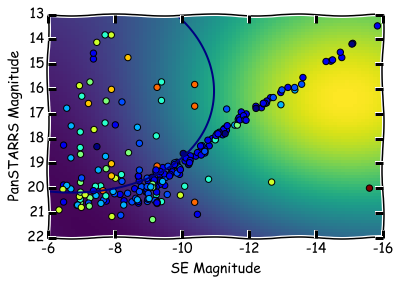

In [127]:
from sklearn import svm
import matplotlib.pyplot as plt

plt.xkcd()
plt.clf()
f, ax2 = plt.subplots()


xx, yy = np.meshgrid(np.linspace(-5, -17, 100),
                     np.linspace(13, 25, 100))

clf = svm.NuSVC(gamma=0.023, nu=0.006,
               kernel="rbf")
clf.fit(X, y)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape([100,100, -1])
Z = Z[:, :, 0]

#print(Z.shape)

ax2.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
           origin='lower', cmap=plt.cm.viridis)

contours = ax2.contour(xx, yy, Z, levels=[2], linewidths=2,
                       linetypes='--', c="white")

ax2.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.jet,
            edgecolors='k')



ax2.set_ylabel("PanSTARRS Magnitude")
ax2.set_xlabel("SE Magnitude")

#ax2.grid(linestyle=':')
plt.xlim(-6, -16)
plt.ylim(22, 13)

#ax1.set_aspect('equal')
plt.savefig(main_dir+"SVM.png", dpi=300)
plt.show()

## Plotting

In [116]:
import plotly.plotly  as py
import plotly.graph_objs as go

In [125]:
trace1 = go.Scatter(
        x = unumpy.nominal_values(err_x_data),
        y = unumpy.nominal_values(err_y_data),

        hoverinfo = "all",

        marker = {
                "size" : 10,
                #"color" : "blue",
                "cmax" : max(e),
                "cmin" : min(e),
                "color" : np.linspace(min(e), max(e), len(e)),
        
                "colorbar" : {
                    "title" : "ELLIPTICITY"
                    },
                "colorscale" : "Viridis"
            },

        mode = 'markers',

        error_y = {
                "type" : "data",
                "array" : unumpy.std_devs(err_y_data),
                "visible" : True,
                "color" : "black"
                  },
    
        error_x = {
                "type" : "data",
                "array" : unumpy.std_devs(err_x_data),
                "visible" : True,
                "color" : "black"
                  }
            )

y_temp = err_x_data*(slope/2) + (intercept-5)
#y_temp = err_x_data*(slope) + (intercept)

trace2 = go.Scatter(
        x = unumpy.nominal_values(err_x_data),
        y = unumpy.nominal_values(y_temp),
        mode = "lines",
        #name = "y = {}*x + {}".format(round(slope,2), round(intercept,2)),
        line = {
            "color" : "orange",
            "width" : 4},
        error_y = {
            "type" : "data",
            "array" : unumpy.std_devs(y_temp*2.0),
            "visible" : True,
            "color" : "orange"
            }
        )


data = [trace2, trace1]

layout = go.Layout(
            showlegend=False,
            title = "{}, Filter: {}".format(obj, filter),
            xaxis = {
                "title" : "SE Magnitude",
                "autorange" : "reversed",
                "mirror" : "ticks",
                "showline" : True,
                "linecolor" : '#636363'
                    },
            yaxis = {
                "title" : "PanSTARRS Magnitude",
                "autorange" : "reversed",
                "mirror" : "ticks",
                "showline" : True,
                "linecolor" : '#636363'
                    }
        )
fig = go.Figure(data = data, layout=layout)

py.iplot(fig, filename='{}_{}_pan_fit_bad'.format(obj, filter))

## Color Color Plots

In [111]:
temp_x = rdata - idata
temp_y = idata - zdata

trace1 = go.Scatter(
        x = unumpy.nominal_values(temp_x),
        y = unumpy.nominal_values(temp_y),

        hoverinfo = "all",

        marker = {
                "size" : 10,
                #"color" : "blue",
                "cmax" : max(e),
                "cmin" : min(e),
                "color" : np.linspace(min(e), max(e), len(e)),
        
                "colorbar" : {
                    "title" : "ELLIPTICITY"
                    },
                "colorscale" : "Viridis"
            },
        error_y = {
        "type" : "data",
        "array" : unumpy.std_devs(temp_y),
        "visible" : True,
        "color" : "#A9A9A9"
          },
    
        error_x = {
                "type" : "data",
                "array" : unumpy.std_devs(temp_x),
                "visible" : True,
                "color" : "#A9A9A9"
                  },
    
        mode = 'markers')

data = [trace1]

layout = go.Layout(
            showlegend=False,
            title = "Color-Color Diagram --- {}".format(obj),
            xaxis = {
                "title" : "r - i",
                "autorange" : "reversed",
                "mirror" : "ticks",
                "showline" : True,
                "linecolor" : '#636363'
                    },
            yaxis = {
                "title" : "i - z",
                "autorange" : "reversed",
                "mirror" : "ticks",
                "showline" : True,
                "linecolor" : '#636363'
                    }
        )

fig = go.Figure(data = data, layout=layout)

py.iplot(fig, filename='{}_cc'.format(obj))

## Reading in SED

In [151]:
sed_data = np.genfromtxt(main_dir+"redshift_curves.txt")

In [152]:
E_sed = sed_data[:,0], sed_data[:,1]
Im_sed = sed_data[:,2], sed_data[:,3]
Sbc_sed = sed_data[:,4], sed_data[:,5]
Scd_sed = sed_data[:,6], sed_data[:,7]

In [153]:
trace1 = go.Scatter(
        x = unumpy.nominal_values(temp_x),
        y = unumpy.nominal_values(temp_y),
        
        name = obj,
        hoverinfo = "all",

        marker = {
                "size" : 8,
                "cmax" : max(e),
                "cmin" : min(e),
                "color" : np.linspace(min(e), max(e), len(e)),
        
                "colorbar" : {
                    "title" : "ELLIPTICITY"
                    },
                "colorscale" : "Viridis"
            },
    
        error_y = {
            "type" : "data",
            "array" : unumpy.std_devs(temp_y),
            "visible" : True,
            "color" : "#A9A9A9",
            "opacity" : 0.6
              },
    
        error_x = {
                "type" : "data",
                "array" : unumpy.std_devs(temp_x),
                "visible" : True,
                "color" : "#A9A9A9",
                "opacity" : 0.3
                  },
    
        mode = 'markers')

data = [trace1]

k = 0
sed_names = ["E_sed", "Im_sed", "Sbc_sed", "Scd_sed"]
for sed, color in zip([E_sed, Im_sed, Sbc_sed, Scd_sed], 
                      ["orange", "cyan", "red", "magenta"]):
    
    xdata, ydata = np.vstack(sed)
    
    trace = go.Scatter(
            x = xdata,
            y = ydata,
            name = sed_names[k],
            mode = "lines",
            line = {
                "color" : color,
                "width" : 4
            }
        )
    
    data.append(trace)
    k +=1
        
layout = go.Layout(
            legend={
                "x" : 0, 
                "y" : 1},
    
            title = "Color-Color Diagram --- {}".format(obj),
            xaxis = {
                "title" : "r - i",
                #"autorange" : "reversed",
                "mirror" : "ticks",
                "showline" : True,
                "linecolor" : '#636363',
                "range" : [-0.75, 1.25]
                    },
            yaxis = {
                "title" : "i - z",
                #"autorange" : "reversed",
                "mirror" : "ticks",
                "showline" : True,
                "linecolor" : '#636363',
                "range" : [-0.5, 4]
                    },
            font = {
                "size" : 14
                }
        )

fig = go.Figure(data = data, layout=layout)

py.iplot(fig, filename='{}_cc_sed_zoom'.format(obj))

## Using UH88 Quantum Efficiency

In [126]:
SEDS = pd.read_csv(main_dir+"SEDS.csv")

In [137]:
SEDS = SEDS.drop("Unnamed: 0", axis=1)

In [139]:
SEDS.head(2)

,E_iz,E_ri,Im_iz,Im_ri,Sbc_iz,Sbc_ri,Scd_iz,Scd_ri
0,0.171859,0.096272,-0.001338,-0.050767,0.162851,0.081582,-0.035385,-0.068584
1,0.418825,0.189788,0.259298,0.000185,0.426162,0.132203,0.219910,0.000128


In [140]:
E_sed = SEDS["E_ri"], SEDS["E_iz"]
Im_sed = SEDS["Im_ri"], SEDS["Im_iz"]
Sbc_sed = SEDS["Sbc_ri"], SEDS["Sbc_iz"]
Scd_sed = SEDS["Scd_ri"], SEDS["Scd_iz"]

In [148]:
trace1 = go.Scatter(
        x = unumpy.nominal_values(temp_x),
        y = unumpy.nominal_values(temp_y),
        
        name = obj,
        hoverinfo = "all",

        marker = {
                "size" : 8,
                "cmax" : max(e),
                "cmin" : min(e),
                "color" : np.linspace(min(e), max(e), len(e)),
        
                "colorbar" : {
                    "title" : "ELLIPTICITY"
                    },
                "colorscale" : "Viridis"
            },
    
        error_y = {
            "type" : "data",
            "array" : unumpy.std_devs(temp_y),
            "visible" : True,
            "color" : "#A9A9A9",
            "opacity" : 0.6
              },
    
        error_x = {
                "type" : "data",
                "array" : unumpy.std_devs(temp_x),
                "visible" : True,
                "color" : "#A9A9A9",
                "opacity" : 0.3
                  },
    
        mode = 'markers')

data = [trace1]

k = 0
sed_names = ["E_sed", "Im_sed", "Sbc_sed", "Scd_sed"]
for sed, color in zip([E_sed, Im_sed, Sbc_sed, Scd_sed], 
                      ["orange", "cyan", "red", "magenta"]):
    
    xdata, ydata = np.vstack(sed)
    
    trace = go.Scatter(
            x = xdata,
            y = ydata,
            name = sed_names[k],
            mode = "lines",
            line = {
                "color" : color,
                "width" : 4
            }
        )
    
    data.append(trace)
    k +=1
        
layout = go.Layout(
            legend={
                "x" : 0, 
                "y" : 1},
    
            title = "Color-Color Diagram --- {}".format(obj),
            xaxis = {
                "title" : "r - i",
                #"autorange" : "reversed",
                "mirror" : "ticks",
                "showline" : True,
                "linecolor" : '#636363',
                "range" : [-0.75, 1.25]
                    },
            yaxis = {
                "title" : "i - z",
                #"autorange" : "reversed",
                "mirror" : "ticks",
                "showline" : True,
                "linecolor" : '#636363',
                "range" : [-0.5, 4]
                    },
            font = {
                "size" : 14
                }
        )

fig = go.Figure(data = data, layout=layout)

py.iplot(fig, filename='{}_cc_sed_QE_zoom'.format(obj))